# Classification - Build a model to predict delayed class

In [1]:
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix,parallel_coordinates
import seaborn as sns
import plotly.express as px
from folium.plugins import HeatMap
import folium
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.preprocessing import scale,LabelEncoder,StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report,silhouette_samples, silhouette_score
import xgboost
import tensorflow as tf
from tensorflow import keras
import shap

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from yellowbrick.cluster.elbow import kelbow_visualizer


from scipy import stats

from statsmodels.tsa.ar_model import AutoReg, ARResults
from statsmodels.tsa import stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from datetime import datetime
from meteostat import Point, Monthly

In [2]:
df_wout=pd.read_csv('df_wout.csv')

In [57]:
del_clas_desc={
'short' : 'delay less than or equal to 36 min',
'medium' : 'delay between 36.1 and 70',
'long' : 'delay greater than 70.1'
}

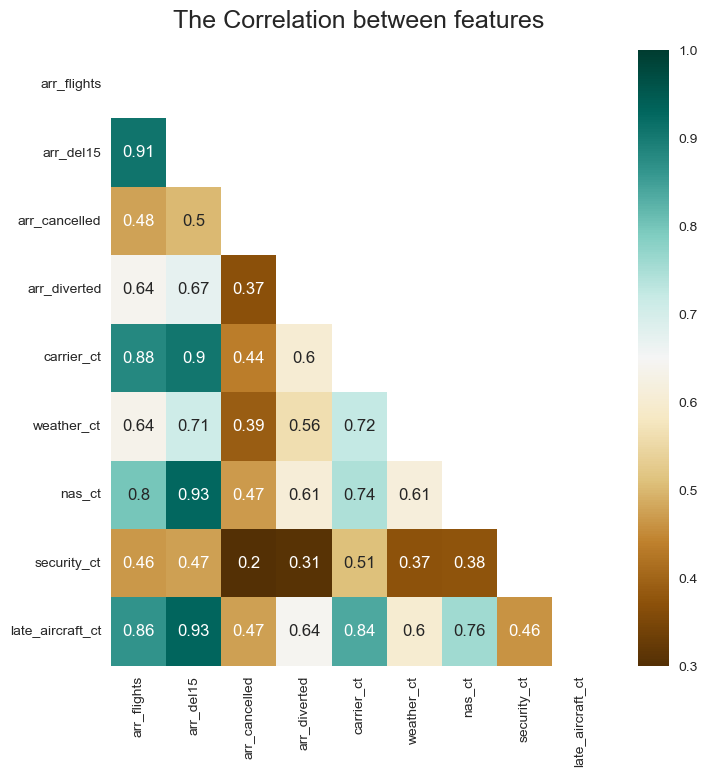

In [13]:
data2=df_wout.loc[:,['arr_flights','arr_del15','arr_cancelled', 'arr_diverted','carrier_ct', 'weather_ct', 'nas_ct','security_ct', 'late_aircraft_ct']]
plt.figure(figsize=(8, 8))
mask = np.triu(np.ones_like(data2.corr(), dtype=bool))
heatmap = sns.heatmap(data2.corr(), mask=mask, vmin=0.3, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('The Correlation between features', fontdict={'fontsize':18}, pad=16);

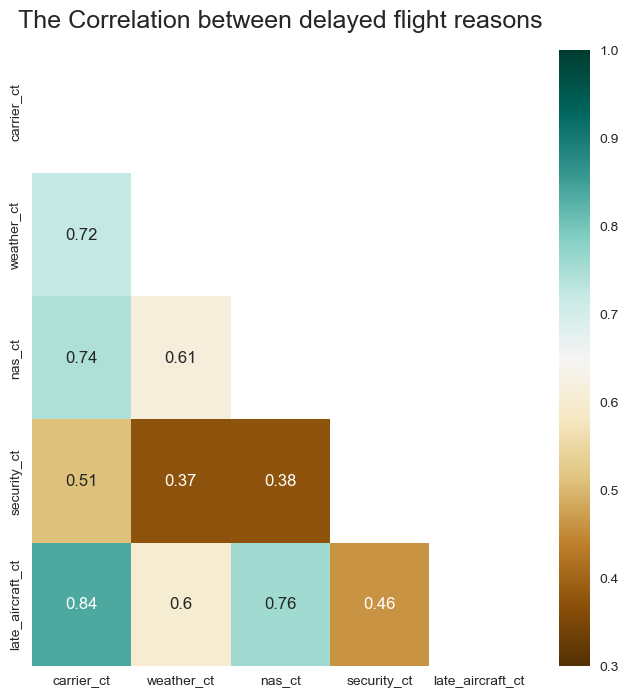

In [14]:
data2=df_wout.loc[:,['carrier_ct', 'weather_ct', 'nas_ct','security_ct', 'late_aircraft_ct']]

plt.figure(figsize=(8, 8))
mask = np.triu(np.ones_like(data2.corr(), dtype=bool))
heatmap = sns.heatmap(data2.corr(), mask=mask, vmin=0.3, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('The Correlation between delayed flight reasons', fontdict={'fontsize':18}, pad=16);

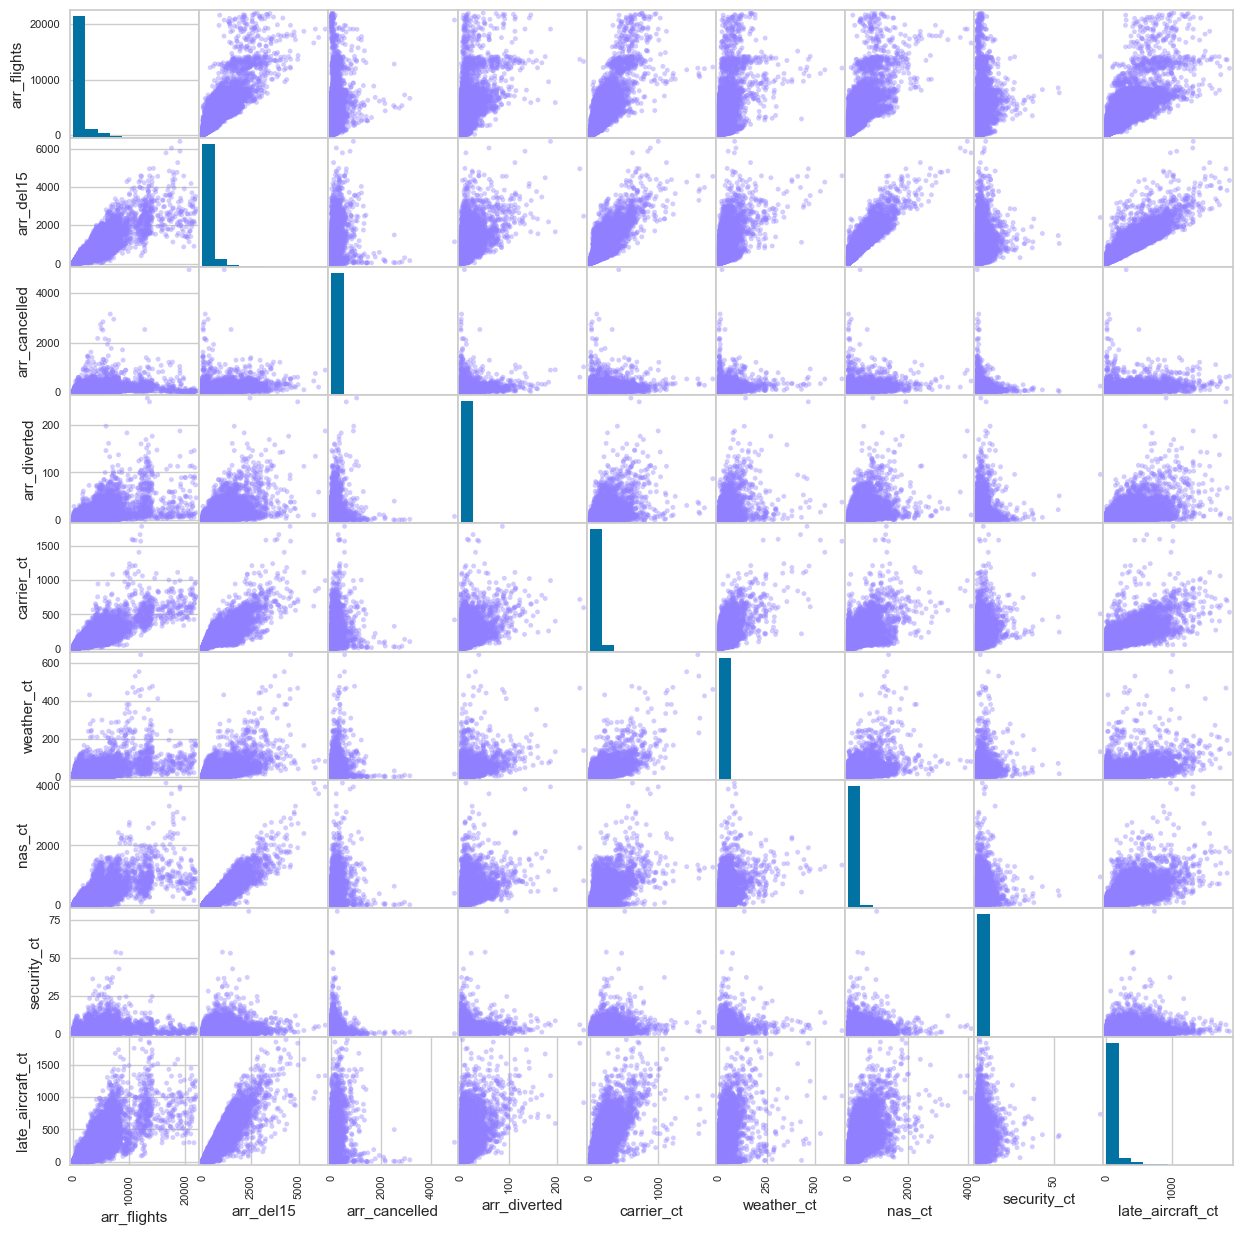

In [54]:
data2=df_wout.loc[:,['arr_flights','arr_del15','arr_cancelled', 'arr_diverted','carrier_ct', 'weather_ct', 'nas_ct','security_ct', 'late_aircraft_ct']]
scatter_matrix(data2 ,alpha=0.4, figsize=(15,15),color="#9080ff");

In [16]:
#Unequal distribution of classes - Class Imbalance
df_wout.del_class.value_counts()

medium    54672
long      10225
short      7788
Name: del_class, dtype: int64

In [17]:
#choose features to make a model for classification
data_imb=df_wout.loc[:,['year', 'month','carrier','airport','state', 'city','del_class']]

In [18]:
# Use Label encoder to encode the levels of categorical features into numeric values 
le=LabelEncoder()

In [19]:
le.fit(data_imb['carrier'])
data_imb['l_carrier']=le.transform(data_imb['carrier'])

In [20]:
le.fit(data_imb['airport'])
data_imb['l_airport']=le.transform(data_imb['airport'])

In [21]:
le.fit(data_imb['state'])
data_imb['l_state']=le.transform(data_imb['state'])

In [22]:
le.fit(data_imb['city'])
data_imb['l_city']=le.transform(data_imb['city'])

In [23]:
le.fit(data_imb['del_class'])
data_imb['l_del_class']=le.transform(data_imb['del_class'])
#long=0 , medium=1 short=2

In [24]:
#Downsampling to balance distribution of classes
ds = np.random.rand(len(data_imb[data_imb['l_del_class']==1])) < 0.3
data=pd.concat([data_imb[data_imb['l_del_class']==1][ds],
                data_imb[data_imb['l_del_class']==0],
                data_imb[data_imb['l_del_class']==2]])
data=data.sample(frac=1)

In [25]:
data.l_del_class.value_counts()

1    16460
0    10225
2     7788
Name: l_del_class, dtype: int64

In [26]:
X=data.loc[:,['year', 'month','l_carrier', 'l_airport', 'l_city']]
y=data.loc[:,'l_del_class']

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [28]:
lr=LogisticRegression(penalty='none',solver='newton-cg')
lr.fit(X_train,y_train)

LogisticRegression(penalty='none', solver='newton-cg')

In [29]:
cmlr=confusion_matrix(y_test,lr.predict(X_test))
print('LogisticRegression : \n' , cmlr)
print('\n',classification_report(y_test, lr.predict(X_test)))

LogisticRegression : 
 [[ 851 1190    0]
 [ 595 2675    0]
 [ 315 1269    0]]

               precision    recall  f1-score   support

           0       0.48      0.42      0.45      2041
           1       0.52      0.82      0.64      3270
           2       0.00      0.00      0.00      1584

    accuracy                           0.51      6895
   macro avg       0.33      0.41      0.36      6895
weighted avg       0.39      0.51      0.43      6895



In [30]:
knn=KNeighborsClassifier(n_neighbors=13,metric='minkowski',p=2)
knn.fit(X_train,y_train)
cmknn=confusion_matrix(y_test,knn.predict(X_test))
print('KNeighborsClassifier : \n' , cmknn)
print('\n',classification_report(y_test, knn.predict(X_test)))

KNeighborsClassifier : 
 [[1266  657  118]
 [ 655 2233  382]
 [ 242  710  632]]

               precision    recall  f1-score   support

           0       0.59      0.62      0.60      2041
           1       0.62      0.68      0.65      3270
           2       0.56      0.40      0.47      1584

    accuracy                           0.60      6895
   macro avg       0.59      0.57      0.57      6895
weighted avg       0.60      0.60      0.59      6895



In [31]:
lda=LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
cmlda=confusion_matrix(y_test,lda.predict(X_test))
print('LinearDiscriminantAnalysis : \n' , cmlda)
print('\n',classification_report(y_test, lda.predict(X_test)))

LinearDiscriminantAnalysis : 
 [[ 867 1174    0]
 [ 616 2654    0]
 [ 322 1262    0]]

               precision    recall  f1-score   support

           0       0.48      0.42      0.45      2041
           1       0.52      0.81      0.63      3270
           2       0.00      0.00      0.00      1584

    accuracy                           0.51      6895
   macro avg       0.33      0.41      0.36      6895
weighted avg       0.39      0.51      0.43      6895



In [32]:
qda=QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train)
cmqda=confusion_matrix(y_test,qda.predict(X_test))
print('QuadraticDiscriminantAnalysis : \n' , cmqda)
print('\n',classification_report(y_test, qda.predict(X_test)))

QuadraticDiscriminantAnalysis : 
 [[ 855 1186    0]
 [ 613 2657    0]
 [ 309 1275    0]]

               precision    recall  f1-score   support

           0       0.48      0.42      0.45      2041
           1       0.52      0.81      0.63      3270
           2       0.00      0.00      0.00      1584

    accuracy                           0.51      6895
   macro avg       0.33      0.41      0.36      6895
weighted avg       0.39      0.51      0.43      6895



In [33]:
gnb=GaussianNB()
gnb.fit(X_train,y_train)
cmgnb=confusion_matrix(y_test,gnb.predict(X_test))
print('GaussianNB : \n' , cmgnb)
print('\n',classification_report(y_test, gnb.predict(X_test)))

GaussianNB : 
 [[ 871 1170    0]
 [ 616 2654    0]
 [ 314 1270    0]]

               precision    recall  f1-score   support

           0       0.48      0.43      0.45      2041
           1       0.52      0.81      0.63      3270
           2       0.00      0.00      0.00      1584

    accuracy                           0.51      6895
   macro avg       0.33      0.41      0.36      6895
weighted avg       0.39      0.51      0.44      6895



In [34]:
dectree=tree.DecisionTreeClassifier(max_depth=13)
dectree.fit(X_train,y_train)
cmdectree=confusion_matrix(y_test,dectree.predict(X_test))
print('DecisionTreeClassifier : \n' , cmdectree)
print('\n',classification_report(y_test, dectree.predict(X_test)))

DecisionTreeClassifier : 
 [[1276  589  176]
 [ 647 2205  418]
 [ 140  634  810]]

               precision    recall  f1-score   support

           0       0.62      0.63      0.62      2041
           1       0.64      0.67      0.66      3270
           2       0.58      0.51      0.54      1584

    accuracy                           0.62      6895
   macro avg       0.61      0.60      0.61      6895
weighted avg       0.62      0.62      0.62      6895



In [35]:
X_train.columns

Index(['year', 'month', 'l_carrier', 'l_airport', 'l_city'], dtype='object')

In [36]:
dectree.feature_importances_

array([0.2463261 , 0.17315772, 0.29421434, 0.14993871, 0.13636313])

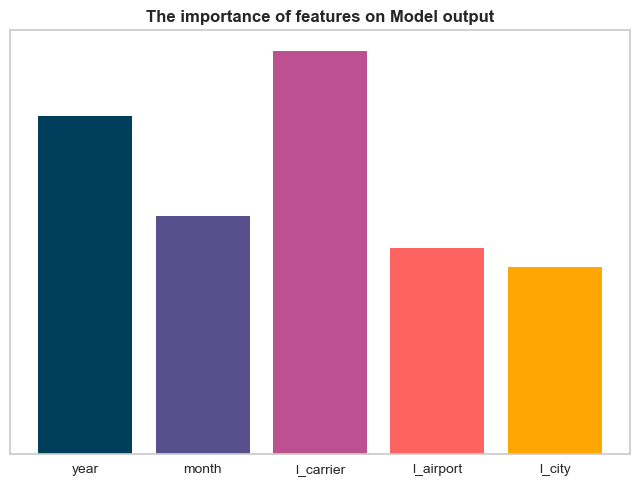

In [41]:
plt.figure()
plt.bar(X_train.columns,dectree.feature_importances_,color=['#003f5c' ,'#58508d', '#bc5090', '#ff6361', '#ffa600'])
plt.grid()
plt.yticks([])
plt.title('The importance of features on Model output',weight='bold');

In [42]:
bag=BaggingClassifier( n_estimators=100)
bag.fit(X_train,y_train)
cmbag=confusion_matrix(y_test,bag.predict(X_test))
print('BaggingClassifier : \n' , cmbag)
print('\n',classification_report(y_test, bag.predict(X_test)))

BaggingClassifier : 
 [[1309  580  152]
 [ 561 2283  426]
 [ 134  497  953]]

               precision    recall  f1-score   support

           0       0.65      0.64      0.65      2041
           1       0.68      0.70      0.69      3270
           2       0.62      0.60      0.61      1584

    accuracy                           0.66      6895
   macro avg       0.65      0.65      0.65      6895
weighted avg       0.66      0.66      0.66      6895



In [43]:
rf=RandomForestClassifier(n_estimators=80,max_features='auto',max_depth=14)
rf.fit(X_train,y_train)
cmrf=confusion_matrix(y_test,rf.predict(X_test))
print('RandomForestClassifier : \n' , cmrf)
print('\n',classification_report(y_test, rf.predict(X_test)))

RandomForestClassifier : 
 [[1264  668  109]
 [ 473 2520  277]
 [ 124  755  705]]

               precision    recall  f1-score   support

           0       0.68      0.62      0.65      2041
           1       0.64      0.77      0.70      3270
           2       0.65      0.45      0.53      1584

    accuracy                           0.65      6895
   macro avg       0.65      0.61      0.62      6895
weighted avg       0.65      0.65      0.64      6895



In [44]:
boost=AdaBoostClassifier(n_estimators=80)
boost.fit(X_train,y_train)
cmboost=confusion_matrix(y_test,boost.predict(X_test))
print('AdaBoostClassifier : \n' , cmboost)
print('\n',classification_report(y_test, boost.predict(X_test)))

AdaBoostClassifier : 
 [[1085  855  101]
 [ 526 2522  222]
 [ 224 1001  359]]

               precision    recall  f1-score   support

           0       0.59      0.53      0.56      2041
           1       0.58      0.77      0.66      3270
           2       0.53      0.23      0.32      1584

    accuracy                           0.58      6895
   macro avg       0.56      0.51      0.51      6895
weighted avg       0.57      0.58      0.55      6895



In [87]:
svm_linear=svm.SVC(C=1,kernel='linear')
svm_linear.fit(X_train,y_train)
cmsvm_linear=confusion_matrix(y_test,svm_linear.predict(X_test))
print('Linear SVM : \n' , cmsvm_linear)
print('\n',classification_report(y_test, svm_linear.predict(X_test)))

Linear SVM : 
 [[   0 2037    0]
 [   0 3336    0]
 [   0 1515    0]]

               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2037
           1       0.48      1.00      0.65      3336
           2       0.00      0.00      0.00      1515

    accuracy                           0.48      6888
   macro avg       0.16      0.33      0.22      6888
weighted avg       0.23      0.48      0.32      6888



In [88]:
#Vanila
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='elu'),
    keras.layers.Dense(100, activation='elu'),
    keras.layers.Dense(100, activation='elu'),
    keras.layers.Dense(100, activation='elu'),
    keras.layers.Dense(3, activation='softmax')
])

In [89]:
model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [90]:
model.fit(X_train,y_train,batch_size=50,epochs=50,verbose=2,validation_split=0.1)

Epoch 1/50
496/496 - 1s - loss: 4.1802 - accuracy: 0.3721 - val_loss: 1.1884 - val_accuracy: 0.4679 - 1s/epoch - 3ms/step
Epoch 2/50
496/496 - 1s - loss: 1.4439 - accuracy: 0.3791 - val_loss: 1.6017 - val_accuracy: 0.2323 - 745ms/epoch - 2ms/step
Epoch 3/50
496/496 - 1s - loss: 1.2764 - accuracy: 0.3931 - val_loss: 1.1978 - val_accuracy: 0.4269 - 707ms/epoch - 1ms/step
Epoch 4/50
496/496 - 1s - loss: 1.2167 - accuracy: 0.4020 - val_loss: 1.1571 - val_accuracy: 0.4690 - 684ms/epoch - 1ms/step
Epoch 5/50
496/496 - 1s - loss: 1.1431 - accuracy: 0.4112 - val_loss: 1.0634 - val_accuracy: 0.4690 - 719ms/epoch - 1ms/step
Epoch 6/50
496/496 - 1s - loss: 1.1065 - accuracy: 0.4300 - val_loss: 1.0669 - val_accuracy: 0.4690 - 683ms/epoch - 1ms/step
Epoch 7/50
496/496 - 1s - loss: 1.0897 - accuracy: 0.4370 - val_loss: 1.2255 - val_accuracy: 0.2987 - 702ms/epoch - 1ms/step
Epoch 8/50
496/496 - 1s - loss: 1.0737 - accuracy: 0.4535 - val_loss: 1.1023 - val_accuracy: 0.4690 - 685ms/epoch - 1ms/step
Epo

In [91]:
model.evaluate(X_test,y_test,verbose=2)

216/216 - 0s - loss: 1.0466 - accuracy: 0.4843 - 407ms/epoch - 2ms/step


[1.0466281175613403, 0.4843205511569977]

In [92]:
yhat=model.predict(X_test)

216/216 [==============================] - 0s 878us/step


In [93]:
pred_class=np.zeros(yhat.shape[0])
for i in range(yhat.shape[0]):
    pred_class[i]=np.argmax(yhat[i])

In [94]:
cmvnn=confusion_matrix(y_test,pred_class)
print('Vanilla Neural Network : \n' , cmvnn)
print('\n',classification_report(y_test, pred_class))

Vanilla Neural Network : 
 [[   0 2037    0]
 [   0 3336    0]
 [   0 1515    0]]

               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2037
           1       0.48      1.00      0.65      3336
           2       0.00      0.00      0.00      1515

    accuracy                           0.48      6888
   macro avg       0.16      0.33      0.22      6888
weighted avg       0.23      0.48      0.32      6888



In [ ]:
Hyperparameters = {'max_depth': np.arange(5,10,1) , 'n_estimators':np.arange(50,250,50) , 'eta' :np.arange(0.2,1.1,0.1) }
xg=xgboost.XGBClassifier()
xg_grid= GridSearchCV(estimator= xg ,param_grid = Hyperparameters, scoring ='accuracy',cv = 10).fit(X_train,y_train)

In [ ]:
xg_grid.best_params_ 

In [45]:
xgb=xgboost.XGBClassifier(eta= 0.2, max_depth= 7, n_estimators= 200)
xgb.fit(X_train,y_train)
cmdxgb=confusion_matrix(y_test,xgb.predict(X_test))
print('XGBoost Classifier : \n' , cmdxgb)
print('\n',classification_report(y_test, xgb.predict(X_test)))

XGBoost Classifier : 
 [[1376  522  143]
 [ 501 2402  367]
 [ 115  499  970]]

               precision    recall  f1-score   support

           0       0.69      0.67      0.68      2041
           1       0.70      0.73      0.72      3270
           2       0.66      0.61      0.63      1584

    accuracy                           0.69      6895
   macro avg       0.68      0.67      0.68      6895
weighted avg       0.69      0.69      0.69      6895



In [46]:
#Evaluate Model by training whole dataset with cross validation algorithm to prevent overfitting

data_imb=data_imb.sample(frac=1)
Ximb=data_imb.loc[:,['year', 'month','l_carrier', 'l_airport', 'l_city']]
yimb=data_imb.loc[:,'l_del_class']



CVS_xgb=cross_val_score(xgb,Ximb,yimb,cv=10)

cmd_xgb_imb=confusion_matrix(yimb,xgb.predict(Ximb))

print( 'Average of cross validation scores =' , np.mean(CVS_xgb) , '\n')
print( 'Standard deviation of cross validation scores =' , np.std(CVS_xgb) , '\n' )
print('XGBoost Classifier : \n' , cmd_xgb_imb,'\n')
print('\n',classification_report(yimb, xgb.predict(Ximb)))

Average of cross validation scores = 0.7948545943362292 

Standard deviation of cross validation scores = 0.003694429676853592 

XGBoost Classifier : 
 [[ 8147  1585   493]
 [ 7215 41927  5530]
 [  310  1555  5923]] 


               precision    recall  f1-score   support

           0       0.52      0.80      0.63     10225
           1       0.93      0.77      0.84     54672
           2       0.50      0.76      0.60      7788

    accuracy                           0.77     72685
   macro avg       0.65      0.77      0.69     72685
weighted avg       0.83      0.77      0.79     72685



In [99]:
explainer=shap.Explainer(xgb.predict,X_test)
shap_values=explainer(X_test)

Exact explainer: 6889it [03:03, 36.08it/s]                                                                             


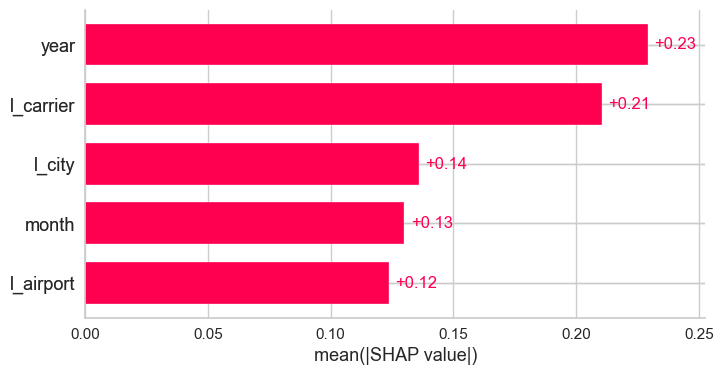

In [100]:
shap.plots.bar(shap_values)

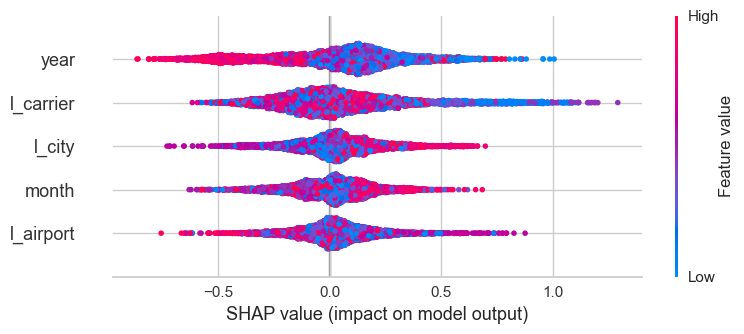

In [101]:
shap.summary_plot(shap_values)

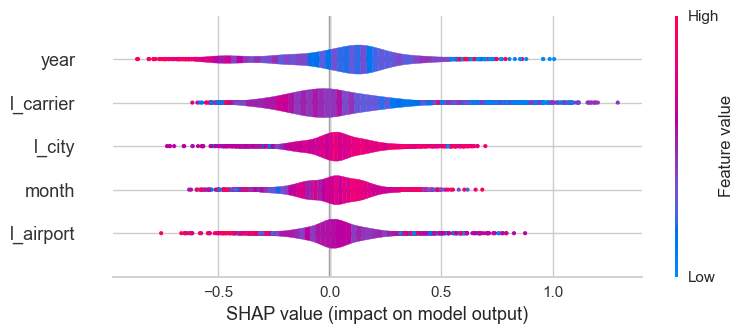

In [102]:
shap.summary_plot(shap_values, plot_type='violin')


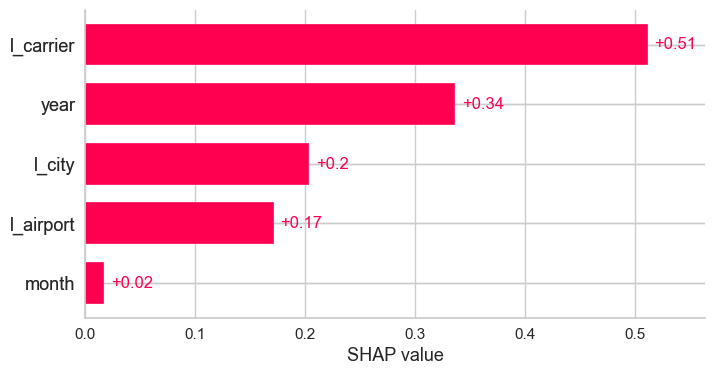

In [103]:
shap.plots.bar(shap_values[800])

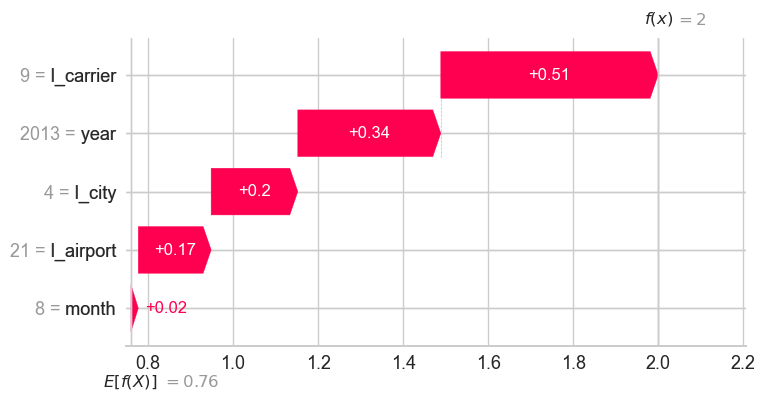

In [104]:
shap.plots.waterfall(shap_values[800])

In [55]:
#New Observation
year=2012
month=11
carrier='AS'
airport='DCA'
city='Washington'

In [58]:
l_carrier=data[data['carrier']==carrier].iloc[0,7]
l_airport=data[data['airport']==airport].iloc[0,8]
l_city=data[data['city']==city].iloc[0,10]
pred=xgb.predict(np.array([[year,month,l_carrier,l_airport,l_city]]))[0]
class_pred=data[data['l_del_class']==pred].iloc[0,6]
print(f'Predicted Delayed : {class_pred} - {del_clas_desc.get(class_pred)}')

Predicted Delayed : short - delay less than or equal to 36 min
